## Clean Technologies 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
categories = pd.read_excel('../data/categories.xlsx')
categories = categories.fillna(method='ffill')
categories.columns = ['sector','group','technology','description','terms','source']
categories.head()

,sector,group,technology,description,terms,source
0,Energy,Solar energy sources,solar PV,Also “solar photovoltaic”; technology of using...,"photovoltaic, PV, “solar cell”",https://www.ctc-n.org/technologies/solar-pv
1,Energy,Solar energy sources,concentrated solar power (CSP),Technology of producing electricity by concent...,"“concentrated solar power”, CSP, “concentrated...",https://setis.ec.europa.eu/technologies/concen...
2,Energy,Solar energy sources,solar heating,Technology of capturing the sun's radiation an...,“solar heating”,https://www.ctc-n.org/technologies/solar-heating
3,Energy,Solar energy sources,solar dryer,"Technology of drying substances, especially fo...",“solar dryer”,https://www.ctc-n.org/technologies/solar-dryer
4,Energy,Solar energy sources,solar water pump,Technology of powering electrical water pumps ...,“solar water pump”,https://www.ctc-n.org/technologies/solar-water...


In [3]:
matrix = []
for term in categories['terms']:
    row = [x.strip() for x in term.split(',')]
    row = [i.replace('“', '').replace('”', '') for i in row]
    matrix.append(row)
categories['terms'] = matrix

In [4]:
terms = [y for x in categories['terms'] for y in x if y != '']

---

In [5]:
cordish2020 = pd.read_excel('../data/cordis-h2020projects.xlsx')

In [6]:
cordish2020['startDate'] = cordish2020['startDate'].map(pd.Timestamp)
cordish2020['endDate'] = cordish2020['endDate'].map(pd.Timestamp)

In [7]:
cordish2020.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,...,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,196618,643555,UNCAP,CLOSED,H2020-EU.3.1.6.,PHC-20-2014,H2020,Ubiquitous iNteroperable Care for Ageing People,2015-01-01,2017-12-31,...,The lack of ICT platforms based on open standa...,3820763.91,3086254.00,H2020-PHC-2014-single-stage,/IA,TRILOGIS SRL,IT,CREATE-NET (CENTER FOR RESEARCH AND TELECOMMUN...,IT;RO;DE;SE;EL;ES;MK;UK;SI,NaN
1,220199,822166,Governance,SIGNED,H2020-EU.3.6.3.;H2020-EU.3.6.1.,GOVERNANCE-14-2018,H2020,Democratic governance in a turbulent age,2018-12-01,2023-11-30,...,Democratic politics and governance in Europe a...,9090927.00,3000000.00,H2020-SC6-GOVERNANCE-2018,/ERA-NET-Cofund,NEDERLANDSE ORGANISATIE VOOR WETENSCHAPPELIJK ...,NL,STYRELSEN FOR FORSKNING OG UDDANNELSE;FONDS ZU...,DK;AT;EE;IS;LT;DE;SE;SI;CZ;ES;FI;PL;UK;NO;CH;I...,NaN
2,220196,822189,BRaVE,SIGNED,H2020-EU.3.6.1.2.,SU-GOVERNANCE-11-2018,H2020,Building Resilience Against Violent Extremism ...,2019-01-01,2021-06-30,...,Far Right and Islamist groups seeking to recru...,1483750.00,1483750.00,H2020-SC6-GOVERNANCE-2018,/CSA,EUROPEAN UNIVERSITY INSTITUTE,IT,DUBLIN CITY UNIVERSITY;KOZEP-EUROPAI EGYETEM;C...,IE;HU;BE;UK;PL;DE,NaN
3,216332,801338,VES4US,SIGNED,H2020-EU.1.2.1.,FETOPEN-01-2016-2017,H2020,Extracellular vesicles from a natural source f...,2018-09-01,2021-08-31,...,"Extracellular vesicles (EVs) are cell-derived,...",2946303.75,2946303.75,H2020-FETOPEN-1-2016-2017,/RIA,CONSIGLIO NAZIONALE DELLE RICERCHE,IT,"ZABALA INNOVATION CONSULTING, S.A.;INSTITUTE O...",ES;IE;CH;DE;SI,NaN
4,216023,770045,DIALLS,SIGNED,H2020-EU.3.6.3.2.,CULT-COOP-03-2017,H2020,DIalogue and Argumentation for cultural Litera...,2018-05-01,2021-04-30,...,DIALLS is a three year project with three obje...,4373308.75,4373308.75,H2020-SC6-CULT-COOP-2017-two-stage,/RIA,THE CHANCELLOR MASTERS AND SCHOLARS OF THE UNI...,UK,EDEX - EDUCATIONAL EXCELLENCE CORPORATION LIMI...,CY;FI;PT;LT;ES;IL;DE;FR,NaN


Objective example

---

In [8]:
cordish2020.loc[13]['objective']

'Slag is a by-product of metal smelting, and ~3.5 million tpa are produced globally in refining Non Ferrous Metals (NFM) and making alloys. Slag contains impurities and forms a protective crust of non-metallic & metallic oxides, and contains significant ‘free’ & alloyed metal (from 10 to 70% by weight). While slag can be used as aggregate, there are increasing concerns over ‘leaching’ of heavy metals into water courses from using these materials in civil engineering. While some metal can be recovered by re-melting slag (at very high temp), this is extremely expensive with very high energy burden which often makes recovery un-economic, but necessary. Landfill of slag is increasingly not an option. Our idea is to use a relatively new technology called ‘implosion’ to selectively break down and separate non-metallic components of slag from metallic particles. This will be combined with ultrasonic vibration sieving for accelerated recovery of metal from the finest fraction. This novel techn

---

#### Flashtext for easy regex

In [9]:
from flashtext import KeywordProcessor

In [10]:
def extract(vec, dictionary, info=False):
    empty = []
    for line in vec:
        empty.append(dictionary.extract_keywords(line, span_info=info))
    return empty

In [11]:
categories_short = categories[['group','technology']] #'sector',
for column in categories_short.columns:
    dictionary = KeywordProcessor()
    dictionary.add_keywords_from_list(list(categories_short[str(column)]))
    extracted = extract(cordish2020['objective'], dictionary)
    #cordish2020['matches_'+str(column)] = extracted
    cordish2020['matches_'+str(column)] = [list(set(i)) if len(i)>0 else '' for i in extracted]
    cordish2020['count_matches_'+str(column)] = [len(i) for i in extracted]
    cordish2020['count_unique_matches_'+str(column)] = [len(set(i)) for i in extracted]

In [12]:
#adding the new list of terms
dictionary = KeywordProcessor()
dictionary.add_keywords_from_list(terms)
extracted = extract(cordish2020['objective'], dictionary)
cordish2020['matches_term'] = [list(set(i)) if len(i)>0 else '' for i in extracted]
cordish2020['count_matches_term'] = [len(i) for i in extracted]
cordish2020['count_unique_matches_term'] = [len(set(i)) for i in extracted]

In [13]:
#extracted

In [14]:
#cordish2020['count_matches'] = cordish2020['count_matches_sector'] + cordish2020['count_matches_group'] + cordish2020['count_matches_technology']
cordish2020['count_matches'] = cordish2020['count_matches_group'] + cordish2020['count_matches_technology'] + cordish2020['count_matches_term']

In [15]:
cordish2020matches = cordish2020[cordish2020['count_matches'] > 0 ]

In [16]:
#cordish2020

In [17]:
print(len(cordish2020matches)/len(cordish2020))

0.1764057859948271


In [18]:
cordish2020matches.id[:20]

9      700626
11     661431
13     651407
15     663654
22     673048
32     663828
33     673373
37     642085
38     634135
41     638661
59     656778
66     656810
72     802862
77     783261
81     829145
82     837614
95     804469
103    814557
105    818635
108    836167
Name: id, dtype: int64

In [19]:
cordish2020matches.sort_values('count_matches', ascending=False).head(10)

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,...,matches_group,count_matches_group,count_unique_matches_group,matches_technology,count_matches_technology,count_unique_matches_technology,matches_term,count_matches_term,count_unique_matches_term,count_matches
8629,197010,673782,FLOATMAST,SIGNED,H2020-EU.3.3.;H2020-EU.2.3.1.,SIE-01-2014-1,H2020,An Innovative Wind Resource Assessment Tension...,2015-06-01,2015-11-30,...,[Wind],15,1,"[onshore wind, offshore wind]",9,2,"[onshore wind, offshore wind]",9,2,33
5503,200472,654462,STEMM-CCS,SIGNED,H2020-EU.3.3.2.3.,LCE-15-2015,H2020,Strategies for Environmental Monitoring of Mar...,2016-03-01,2020-02-29,...,"[Storage, CCS]",15,2,[carbon capture and storage],1,1,"[carbon capture and storage, CCS]",13,2,29
18909,200258,691799,UPWAVE,TERMINATED,H2020-EU.3.3.;H2020-EU.3.;H2020-EU.3.3.2.4.;H2...,LCE-03-2015,H2020,Demonstration of a 1-MW wave energy converter ...,2016-02-01,2021-01-31,...,[Wind],8,1,"[wave energy, offshore wind]",9,2,"[renewable energy, wave energy, offshore wind]",10,3,27
19556,199423,691712,ACT,SIGNED,H2020-EU.3.3.2.;H2020-EU.3.3.3.;H2020-EU.3.3.4.,LCE-18-2015,H2020,Accellerating CCS technologies as a new low-ca...,2016-02-01,2021-01-31,...,"[Storage, CCS]",14,2,,0,0,[CCS],13,1,27
6770,207129,744518,FLOWSPA,SIGNED,H2020-EU.3.3.;H2020-EU.2.1.1.;H2020-EU.2.3.1.,SMEInst-09-2016-2017,H2020,Floating Offshore Wind Support Platform and As...,2017-02-01,2017-09-30,...,[Wind],11,1,[offshore wind],8,1,[offshore wind],8,1,27
11297,215270,794562,Small-scale CSP,SIGNED,H2020-EU.1.3.2.,MSCA-IF-2017,H2020,Numerical and experimental analysis of a novel...,2018-06-01,2020-05-31,...,[Storage],7,1,"[thermal storage, energy storage, concentrated...",4,3,"[concentrated solar power, Fresnel reflector, ...",15,6,26
3034,213067,779541,REMOTE,SIGNED,H2020-EU.3.3.8.2.;H2020-EU.3.3.8.3.,FCH-02-12-2017,H2020,Remote area Energy supply with Multiple Option...,2018-01-01,2021-12-31,...,"[Storage, Wind, Fuel]",7,3,"[micro-grids, energy storage, fuel cell]",6,3,"[CHP, PV, micro-grid, energy storage, fuel cell]",12,5,25
20293,194405,645963,SENSIBLE,SIGNED,H2020-EU.3.3.,LCE-08-2014,H2020,Storage-Enabled Sustainable Energy for Buildin...,2015-01-01,2018-06-30,...,"[Storage, Energy management]",13,2,"[heat pumps, energy storage, thermal storage]",4,3,"[CHP, PV, thermal storage, renewable energy, e...",7,5,24
7073,197929,671396,AutoRE,SIGNED,H2020-EU.3.3.8.1.,FCH-02.5-2014,H2020,AUTomotive deRivative Energy system,2015-08-01,2018-07-31,...,[Fuel],7,1,"[combined heat and power (CHP), fuel cell]",6,2,"[combined heat and power, CHP, fuel cell]",11,3,24
14413,213276,790379,Turbo-FuelCell,SIGNED,H2020-EU.3.4.;H2020-EU.2.1.1.;H2020-EU.2.3.1.,SMEInst-10-2016-2017,H2020,"Compact, light, efficient and reliable turbo c...",2017-12-01,2018-03-31,...,"[Storage, Fuel]",9,2,[fuel cell],7,1,"[electric vehicle, fuel cell]",8,2,24


There is one hypthesis here:  
The more count matches you have the better the accuracy to detect technology terms in the objective text  
Might be solved with statistical sampling. For each count match, select a sample check manually the accuracy  
http://www.marknagelberg.com/using-python-to-figure-out-sample-sizes-for-your-study/

EDA
1. Group by month and count over the time
2. Group by month and sum the total cost over the time
3. Group by country coordinator and count

In [20]:
dfy = cordish2020matches.groupby(cordish2020matches['startDate'].map(lambda x: x.year)).count()['id']

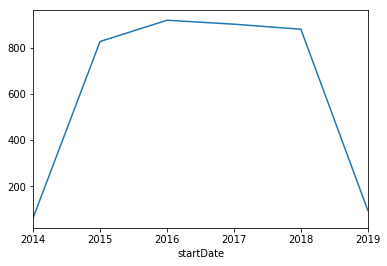

In [21]:
dfy.plot()

In [22]:
dfc = cordish2020matches.groupby(cordish2020matches['startDate'].map(lambda x: x.year)).sum()['totalCost']

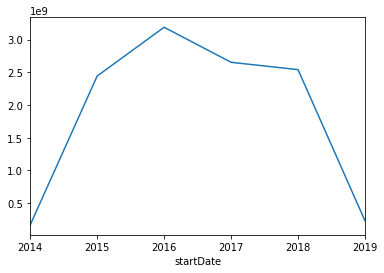

In [23]:
dfc.plot()

In [24]:
df_c = cordish2020matches.groupby(['coordinator','coordinatorCountry']).count()['id'].sort_values(ascending=False).reset_index()
df_c.columns = ['coordinator','coordinatorCountry','count']

In [25]:
df_c.head(20)

,coordinator,coordinatorCountry,count
0,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,FR,63
1,THE CHANCELLOR MASTERS AND SCHOLARS OF THE UNI...,UK,36
2,FRAUNHOFER GESELLSCHAFT ZUR FOERDERUNG DER ANG...,DE,35
3,COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...,FR,33
4,DEUTSCHES ZENTRUM FUER LUFT - UND RAUMFAHRT EV,DE,29
5,TECHNISCHE UNIVERSITEIT DELFT,NL,28
6,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,UK,26
7,"THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UN...",UK,21
8,FUNDACION TECNALIA RESEARCH & INNOVATION,ES,20
9,THE UNIVERSITY OF NOTTINGHAM,UK,19


In [26]:
cordish2020matches.columns

Index(['rcn', 'id', 'acronym', 'status', 'programme', 'topics',
       'frameworkProgramme', 'title', 'startDate', 'endDate', 'projectUrl',
       'objective', 'totalCost', 'ecMaxContribution', 'call', 'fundingScheme',
       'coordinator', 'coordinatorCountry', 'participants',
       'participantCountries', 'subjects', 'matches_group',
       'count_matches_group', 'count_unique_matches_group',
       'matches_technology', 'count_matches_technology',
       'count_unique_matches_technology', 'matches_term', 'count_matches_term',
       'count_unique_matches_term', 'count_matches'],
      dtype='object')

In [27]:
def get_terms_matrix(vector_of_terms, all_terms):
    matrix = []
    for vector in vector_of_terms:
        ind_vector = [0] * len(all_terms)
        for v in vector:
            for idx, i in enumerate(all_terms):
                if v == i:
                    ind_vector[idx] = 1
        matrix.append(ind_vector)
    table = pd.DataFrame(matrix)
    return table

In [28]:
all_terms = [i for i in set([*list(categories['sector']), *list(categories['group']), *list(categories['technology']), *list(terms)])]

In [29]:
all_terms[:10]

['data center',
 'non-motorised transport design',
 'alternative to meat',
 'efficient energy transmission',
 'electric battery',
 'Condebelt drying',
 'management of livestock',
 'coal fly ash',
 'gasification of waste',
 'management of traffic']

In [30]:
matches_term_table = get_terms_matrix(list(cordish2020matches['matches_term']), all_terms)
matches_technology_table = get_terms_matrix(list(cordish2020matches['matches_technology']), all_terms)
matches_group_table = get_terms_matrix(list(cordish2020matches['matches_group']), all_terms)
#matches_sector_table = get_terms_matrix(list(cordish2020matches['matches_sector']), all_terms)

In [31]:
#matches_table = matches_sector_table + matches_group_table + matches_technology_table + matches_term_table
matches_table = matches_group_table + matches_technology_table + matches_term_table

In [32]:
matches_table.columns = all_terms

In [33]:
matches_table['count'] = matches_table.sum(axis=1)

In [34]:
matches_table.head()

,data center,non-motorised transport design,alternative to meat,efficient energy transmission,electric battery,Condebelt drying,management of livestock,coal fly ash,gasification of waste,management of traffic,...,low carbon building,intelligent grid,Hydro energy sources,combined heat and power,geothermal energy,photovoltaic,compressed natural gas,straw management,management of soil,count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
len(matches_table)

3683

In [36]:
full_table_tech_matches = pd.concat([cordish2020matches.reset_index(), matches_table], axis=1).sort_values(['count_matches','count'], ascending=False).reset_index()

In [37]:
len(full_table_tech_matches)

3683

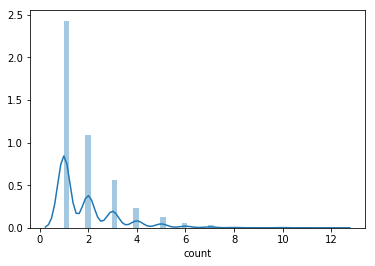

In [38]:
import seaborn as sns
sns.distplot(full_table_tech_matches['count'])

In [39]:
full_table_tech_matches[['id','acronym','title','objective','count','count_matches']].head(30)
full_table_tech_matches[['id','acronym','title','objective','count','count_matches']].to_csv('tech.csv')

In [40]:
termsT = full_table_tech_matches.iloc[:,33:-1].T
termsT['sum'] = termsT.sum(axis=1)

In [41]:
termsT.sort_values('sum', ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,3674,3675,3676,3677,3678,3679,3680,3681,3682,sum
Storage,0,1,0,0,1,1,1,1,0,1,...,0,0,0,1,0,0,1,0,0,784
Fuel,0,0,0,0,0,0,1,0,1,1,...,1,0,0,0,1,0,0,0,0,686
recycling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,502
energy storage,0,0,0,0,0,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,386
renewable energy,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,380
aircraft,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,373
Wind,1,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,344
logistics,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,215
car,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,208
fuel cell,0,0,0,0,0,0,2,0,2,2,...,0,0,0,0,0,0,0,0,0,190


In [42]:
len(termsT[termsT['sum']>0])/len(termsT)

0.4888888888888889

In [46]:
all_terms

['data center',
 'non-motorised transport design',
 'alternative to meat',
 'efficient energy transmission',
 'electric battery',
 'Condebelt drying',
 'management of livestock',
 'coal fly ash',
 'gasification of waste',
 'management of traffic',
 'biorefinery design',
 'osmotic',
 'low GHG cement',
 'car',
 'low GHG fertiliser',
 'converted gas',
 'Transport',
 'Energy use innovation',
 'passive house',
 'low GHG lighting',
 'CHP',
 'lightweight transport',
 'low-carbon building',
 'CCS',
 'geothermal power',
 'RAPS',
 'efficient lighting',
 'Resource saving',
 'low-carbon house',
 'management of nutrient',
 'Energy management',
 'renewable energy',
 'gasification of municipal solid waste',
 'low GHG air conditioning',
 'low GHG envelope',
 'solar cell',
 'blast furnace slag',
 'recycling',
 'Wind',
 'high efficiency lighting',
 'high-efficiency electric power transmission',
 'concentrated solar',
 'alternatives to meat',
 'grid management',
 'Fresnel reflector',
 'Nuclear energy sou

#### Syntactic probabilistic classification using spacy and fuzzywuzzy

In [43]:
import spacy
import numpy as np
from spacy import displacy
from collections import Counter
import en_core_web_sm
from fuzzywuzzy import process, fuzz
import re
nlp = en_core_web_sm.load()
import textdistance as tx
import unicodedata
from textdistance.algorithms import vector_based

In [47]:
def clean(string):
    return re.sub(r'[-\s]+', '-',
                str(
                    re.sub(r'[^\w\s-]', '',
                        unicodedata.normalize('NFKD', string)
                    .strip()
                   )))

In [48]:
cordish2020.loc[13]['objective']

'Slag is a by-product of metal smelting, and ~3.5 million tpa are produced globally in refining Non Ferrous Metals (NFM) and making alloys. Slag contains impurities and forms a protective crust of non-metallic & metallic oxides, and contains significant ‘free’ & alloyed metal (from 10 to 70% by weight). While slag can be used as aggregate, there are increasing concerns over ‘leaching’ of heavy metals into water courses from using these materials in civil engineering. While some metal can be recovered by re-melting slag (at very high temp), this is extremely expensive with very high energy burden which often makes recovery un-economic, but necessary. Landfill of slag is increasingly not an option. Our idea is to use a relatively new technology called ‘implosion’ to selectively break down and separate non-metallic components of slag from metallic particles. This will be combined with ultrasonic vibration sieving for accelerated recovery of metal from the finest fraction. This novel techn

In [49]:
text = cordish2020['objective'][13]
doc = nlp(text)
docs = list(map(str, doc.noun_chunks))
docs

['Slag',
 'a by-product',
 'metal smelting',
 '~3.5 million tpa',
 'refining',
 'Non Ferrous Metals',
 'NFM',
 'alloys',
 'Slag',
 'impurities',
 'a protective crust',
 'metallic oxides',
 'significant ‘free’',
 'alloyed metal',
 '10 to 70%',
 'weight',
 'slag',
 'concerns',
 '‘leaching’',
 'heavy metals',
 'water courses',
 'these materials',
 'civil engineering',
 'some metal',
 're-melting slag',
 'very high temp',
 'very high energy burden',
 'recovery',
 'Landfill',
 'slag',
 'an option',
 'Our idea',
 'a relatively new technology',
 'non-metallic components',
 'slag',
 'metallic particles',
 'ultrasonic vibration',
 'accelerated recovery',
 'metal',
 'the finest fraction',
 'This novel technology',
 'waste glass',
 'it',
 '‘sand’',
 'uniform size',
 'no ‘sharps’',
 'normal crushing techniques',
 'This technology',
 'other materials',
 'Benefits',
 'partners',
 'endusers',
 'society',
 'Rapid recovery',
 'more metal',
 'slag',
 'relatively low cost',
 'Strategic control',
 'metal'

**Get all the synonyms from the short descriptions**

In [25]:
#categories2 = pd.read_excel('../data/categories.xlsx')
#categories2 = categories2.fillna(method='ffill')
#categories2.head()

,IPCC sectoral category,Technology group,Technology,Short description,Source
0,Energy,Solar energy sources,solar PV,Also “solar photovoltaic”; technology of using...,https://www.ctc-n.org/technologies/solar-pv
1,Energy,Solar energy sources,concentrated solar power (CSP),Technology of producing electricity by concent...,https://setis.ec.europa.eu/technologies/concen...
2,Energy,Solar energy sources,solar heating,Technology of capturing the sun's radiation an...,https://www.ctc-n.org/technologies/solar-heating
3,Energy,Solar energy sources,solar dryer,"Technology of drying substances, especially fo...",https://www.ctc-n.org/technologies/solar-dryer
4,Energy,Solar energy sources,solar water pump,Technology of powering electrical water pumps ...,https://www.ctc-n.org/technologies/solar-water...


In [50]:
#technologies = re.findall('“([^“]*)”', " ".join(categories2['Short description']))
#technologies

NameError: name 'technologies' is not defined

In [27]:
#technologies.extend(categories2['Technology'])
#technologies.extend(['carbon emmisions', 'new technology'])

In [28]:
#technologies = list(set(technologies))

In [51]:
#technologies = [clean(str(txt)) for txt in technologies]
technologies = all_terms

In [52]:
def find_best_matching_tech(techs, doc):
    best_matches = []
    best1 = [("", 0)]
    best2 = [("", 0)]
    val2=""
    best_tech = []
    for val in techs:
        best_curs = process.extract(val, doc, limit=1, scorer=fuzz.ratio)
        terms = ""
        for cat in best_curs:
            terms = terms + cat[0] + "," 
        terms = terms[:-1]
        if len(best_curs)==0:
            avg = 0
        else:
            avg = sum(i for _, i in best_curs)/float(len(best_curs))
        best_cur = [(terms, avg)]
        best_matches.extend(best_cur)
        if best_cur[0][1] > best1[0][1]:
            best1 = best_cur
            best_tech = [val]
        elif best_cur[0][1] == best1[0][1]:
            best1.extend(best_cur)
            best_tech.append(val)
        else:
            if best_cur[0][1] > best2[0][1] and len(best1)<3:
                best2 = best_cur
                val2 = val
    if len(best1)<3:            
        best1.extend(best2)
        best_tech.append(val2)
    return best_matches, best_tech, best1

In [54]:
cordish2020['category'] = pd.Series(np.random.randn(len(cordish2020)), index=cordish2020.index)
for idx in range(len(cordish2020['objective'])):
    text = cordish2020['objective'][idx]
    doc = nlp(text)
   # doc = " ".join([token.lemma_ for token in doc])
    #doc = nlp(doc)
    docs = list(map(str, doc.noun_chunks))
    #docs = [clean(str(txt)) for txt in docs]
    _, best_tech, best_match = find_best_matching_tech(technologies, docs)
    #print(best_tech, best_match)
    if round(best_match[0][1]) > 77:
        cordish2020['category'][idx] = " ".join(best_tech)
    else:
        cordish2020['category'][idx] = 'None'


c:\users\seun.adekunle\appdata\local\continuum\anaconda3\envs\myml\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\users\seun.adekunle\appdata\local\continuum\anaconda3\envs\myml\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\seun.adekunle\appdata\local\continuum\anaconda3\envs\myml\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [55]:
cordish2020['category'].value_counts()['None']

11413

In [56]:
cordish2020matches2 = cordish2020[cordish2020['category'] != "None" ]

In [57]:
print(len(cordish2020matches2)/len(cordish2020))

0.4533480218411725


In [58]:
cordish2020matches2.id[:20]

0     643555
1     822166
11    661431
13    651407
15    663654
16    666092
20    644271
22    673048
23    663865
24    641003
25    661555
26    666100
28    664168
31    663704
32    663828
33    673373
34    653750
37    642085
38    634135
41    638661
Name: id, dtype: int64

In [59]:
cordish2020matches2.head(20)

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,...,count_matches_group,count_unique_matches_group,matches_technology,count_matches_technology,count_unique_matches_technology,matches_term,count_matches_term,count_unique_matches_term,count_matches,category
0,196618,643555,UNCAP,CLOSED,H2020-EU.3.1.6.,PHC-20-2014,H2020,Ubiquitous iNteroperable Care for Ageing People,2015-01-01,2017-12-31,...,0,0,,0,0,,0,0,0,Improved durability improved durability air co...
1,220199,822166,Governance,SIGNED,H2020-EU.3.6.3.;H2020-EU.3.6.1.,GOVERNANCE-14-2018,H2020,Democratic governance in a turbulent age,2018-12-01,2023-11-30,...,0,0,,0,0,,0,0,0,reforestation Storage
11,196096,661431,RE-DEV,CLOSED,H2020-EU.1.3.2.,MSCA-IF-2014-EF,H2020,Assessing the transition to renewable energy i...,2015-11-06,2017-11-05,...,0,0,,0,0,[renewable energy],5,1,5,renewable energy wave energy
13,196637,651407,Ultroslag,CLOSED,H2020-EU.3.5.;H2020-EU.2.3.1.,SC5-20-2014-1,H2020,A new integrated sustainable processing system...,2014-10-01,2015-03-31,...,0,0,[recycling],1,1,[recycling],1,1,2,geothermal energy freight
15,196272,663654,HESS,CLOSED,H2020-EU.3.3.;H2020-EU.2.3.1.,SIE-01-2014-1,H2020,Hybrid Energy Storage System,2015-02-01,2015-07-31,...,8,3,[energy storage],1,1,"[renewable energy, energy storage]",2,2,11,Other renewable energy sources Solar energy so...
16,196376,666092,REACTION,CLOSED,H2020-EU.3.1.,Health,H2020,Evaluation of the efficacy and of the antivira...,2014-11-01,2017-10-31,...,0,0,,0,0,,0,0,0,soil treatment treatment of soil
20,196623,644271,AEROARMS,SIGNED,H2020-EU.2.1.1.5.,ICT-23-2014,H2020,AErial RObotic system integrating multiple A...,2015-06-01,2019-05-31,...,0,0,,0,0,,0,0,0,aviation pump system
22,196487,673048,WeSmartPark,CLOSED,H2020-EU.3.4.;H2020-EU.2.3.1.,IT-1-2014-1,H2020,Giving Drivers Access to Conventional and Elec...,2015-03-01,2015-05-31,...,0,0,,0,0,[electric car],4,1,4,electric car nutrient management
23,196288,663865,SUNIGENT,CLOSED,H2020-EU.3.3.;H2020-EU.2.3.1.,SIE-01-2014-1,H2020,Intelligent sunlight system for energy efficie...,2015-03-01,2015-06-30,...,0,0,,0,0,,0,0,0,System innovation high efficiency lighting
24,196608,641003,C-ENERGY 2020,SIGNED,H2020-EU.3.3.,LCE-22-2014,H2020,Connecting Energy National Contact Points in a...,2014-12-01,2018-11-30,...,0,0,,0,0,,0,0,0,Energy energy storage


In [31]:
text = cordish2020['objective'][13]
doc = nlp(text)
#doc = " ".join([token.lemma_ for token in doc])
#doc = nlp(doc)
docs = list(map(str, doc.noun_chunks))
_, best_tech, best_match = find_best_matching_tech(technologies, docs)
print(best_tech,best_match)

['soil management', 'reuse of material'] [('Slag,Slag,slag,slag,slag', 0.7555555555555555), ('these materials,other materials,Non Ferrous Metals,more metal,The ultimate goal', 0.7344169991228815)]
